# Atividade 03 - Parte 01

## Modelagem de Dispersão

Função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas.

Conforme a taxa de emissão da empresa Diamante - Capivari de Baixo

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados do arquivo METEO.csv, ignorando linhas problemáticas
arquivo_csv = r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\outputs\METEO.SFC.csv"

# Leitura do arquivo CSV
dados = pd.read_csv(arquivo_csv)

# Localizando o índice da linha com o texto indesejado
index_to_drop = dados[dados.isna().any(axis=1)].index

# Excluindo a linha com o texto indesejado do DataFrame
dados = dados.drop(index_to_drop)

# Convertendo as colunas
dados['Year'] = dados['Year'].astype(str)
dados['Month_[1-12]'] = dados['Month_[1-12]'].astype(int)
dados['Day_[1-31]'] = dados['Day_[1-31]'].astype(int)
dados['Month_[1-12]'] = dados['Month_[1-12]'].astype(str)
dados['Day_[1-31]'] = dados['Day_[1-31]'].astype(str)

# Concatenando as colunas 'Year', 'Month_[1-12]' e 'Day_[1-31]' para formar a data no formato 'YYYY-MM-DD'
dados['Date'] = dados['Year'] + '-' + dados['Month_[1-12]'] + '-' + dados['Day_[1-31]']
dados['datetime'] = pd.to_datetime(dados['Date'], format='%y-%m-%d')

# Definir a coluna datetime como índice dos dados
dados.set_index('datetime', inplace=True)

# Selecionar 5 dias de verão e 5 dias de inverno aleatoriamente
verao = dados[(dados.index.month >= 12) | (dados.index.month <= 2)].sample(n=5, random_state=1)
inverno = dados[(dados.index.month >= 6) & (dados.index.month <= 8)].sample(n=5, random_state=1)

# Concatenar os dias selecionados para formar o conjunto de dados de interesse
selecionados = pd.concat([verao, inverno])

# Filtrando apenas colunas numéricas para calcular a média
colunas_numericas = selecionados.select_dtypes(include=['float64', 'int64']).columns
medias_diarias = selecionados[colunas_numericas].groupby(selecionados.index.date).mean()

# Definir uma função para determinar a classe de estabilidade
def determinar_classe_estabilidade(row):
    cobertura_nuvens = row['Cloud_Cover_[tenths]']
    velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
    fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
    
    if fluxo_calor_sensivel > 10:
        insolacao = 'forte'
    elif 3 < fluxo_calor_sensivel <= 10:
        insolacao = 'moderada'
    else:
        insolacao = 'fraca'

    if cobertura_nuvens < 3:
        if velocidade_vento < 2:
            return 'A' if insolacao == 'forte' else 'B'
        elif 2 <= velocidade_vento < 3:
            return 'B' if insolacao == 'forte' else 'C'
        else:
            return 'C'
    elif 3 <= cobertura_nuvens < 7:
        if velocidade_vento < 2:
            return 'B' if insolacao == 'forte' else 'C'
        elif 2 <= velocidade_vento < 5:
            return 'C'
        else:
            return 'D'
    else:
        if velocidade_vento < 2:
            return 'C'
        elif 2 <= velocidade_vento < 5:
            return 'D'
        else:
            return 'E'

# Aplicar a função para cada linha de dados e adicionar a classe de estabilidade como uma coluna
medias_diarias['classe_estabilidade'] = medias_diarias.apply(determinar_classe_estabilidade, axis=1)

# Exibir os resultados finais, incluindo os parâmetros e a classe de estabilidade
print(medias_diarias[['Cloud_Cover_[tenths]', 'Surface_Friction_Velocity_[meters/second]', 'Sensible_Heat_Flux_[Watt/meter^2]', 'classe_estabilidade']])

            Cloud_Cover_[tenths]  Surface_Friction_Velocity_[meters/second]  \
2023-01-11                   6.0                                      0.299   
2023-01-25                   1.0                                      0.129   
2023-02-11                  99.0                                     -9.000   
2023-06-09                  99.0                                     -9.000   
2023-06-18                   3.0                                      0.202   
2023-07-22                   6.0                                      0.389   
2023-08-05                  99.0                                     -9.000   
2023-08-14                   1.0                                      0.424   
2023-12-02                   6.0                                      0.111   
2023-12-17                   6.0                                      0.704   

            Sensible_Heat_Flux_[Watt/meter^2] classe_estabilidade  
2023-01-11                              -26.1                 

### Função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade.

In [38]:
def sigmaYZ(x, classe, urbOrRural):
    if urbOrRural == 'urbano':
        if classe == 'A' or classe == 'B':
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** 0.5
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E' or classe == 'F':
            sigmaY = 0.11 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            raise ValueError('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            raise ValueError('Classe de estabilidade errada')
    else:
        raise ValueError('Tipo de ambiente deve ser "urbano" ou "rural"')
    
    return sigmaY, sigmaZ

### Função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs.

In [39]:
# Considerando o efeito Tip-Downwhash
def hg_tip_downwash(hg, d, vs, u):
    if vs >= 1.5 * u:
        hg2 = hg + (2 * d * ((vs / u) - 1.5))
        print('A pluma caiu')
    else:
        hg2 = hg 
        print('A pluma subiu')
    return hg2

In [40]:
# Função para calcular Fb
def calcular_fb(Ta, Ts, rc, Vs):
    g = 9.8  # m/s²
    Qo = np.pi * rc**2 * Vs  # vazão volumétrica de gases
    Fb = (g / np.pi) * Qo * (1 - (Ta / Ts))
    return Fb

# Função para calcular Fm
def calcular_fm(Vs, d, Ta, Ts):
    Fm = (Vs ** 2) * (d ** 2) * (Ta / (4 * Ts))
    return Fm
    
def sobrelevacaoBriggs(Fb, Fm, Vs, d, u, deltaT, Ts, He, classe):
    """
    Calcula a sobrelevação da pluma usando o modelo de Briggs adaptado para diferentes tipos de atmosfera.
    """
    # Determinar se a atmosfera é instável ou estável com base na classe de Pasquill
    tipo_atmosfera = 'instavel' if classe in ['A', 'B', 'C', 'D'] else 'estavel'
    
    # Calcular (ΔT)e com base no tipo de atmosfera
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            deltaTe = 0.0297 * Ts * ((Vs ** (1/3)) / (d ** (2/3)))
        else:
            deltaTe = 0.00575 * Ts * ((Vs ** (2/3)) / (d ** (1/3)))
    else:
        deltaTe = 0.01958 * Ts * ((Vs ** 0.5) * (Fb ** 0.5))
        
    # Calcular H com base nas condições fornecidas
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 21.425 * ((Fb ** (3/4)) / (u ** (1/2)))
        else:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 2.6 * ((Fm ** (1/3)) / (u ** (1/3)))
    else:
        if deltaT < deltaTe:
            H = He + 1.5 * ((Fm ** (1/3)) / (u ** (1/3)))
        else:
            H = He + 2.6 * ((Fm ** (1/3)) / (u ** (1/3)))
    print(H,He)
    return H - He

### Função do modelo gaussiano

In [41]:
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

### Simulações

#### Simulação 1


Resultados Simulação
Classe de Estabilidade: C
A pluma caiu
83.13411684144155 67.5
Sobrelevação da pluma (Briggs): 15.63 m


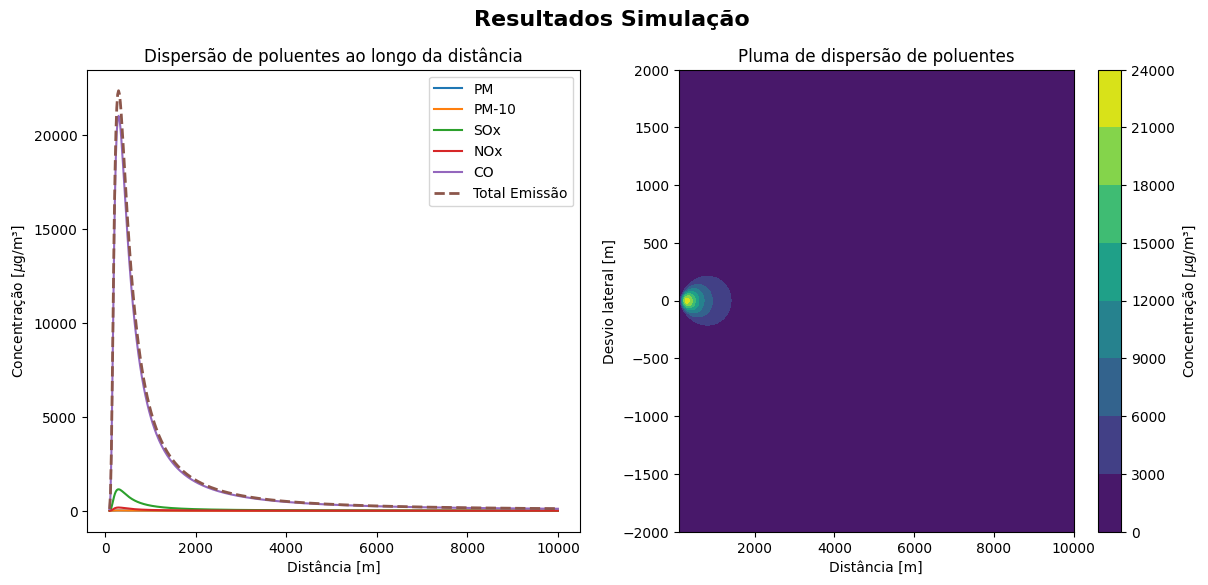

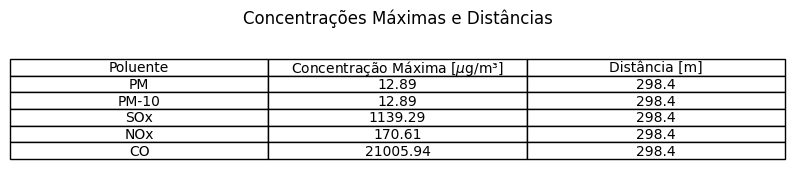

In [42]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # Velocidade do vento (m/s)
    'y': 0,                     # Estimando na direção do vento
    'z': 1.5,                   # Altura do nariz (m)
    'H': 50,                    # Altura de liberação da pluma (m)
    'urbOrRural': 'urbano',     # Tipo de ambiente (urbano ou rural)
    'rc': lambda d: d / 2,      # Raio da chaminé (função lambda)
    'd': 3.5,                   # Diâmetro da chaminé (m)
    'Vs': 20,                   # Velocidade de saída do gás (m/s)
    'p': 1013,                  # Pressão atmosférica (hPa)
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente (°C)
    'Ts': 533,                  # Temperatura de saída da pluma (°C)
    'Ta': lambda deltaT, Ts: Ts - deltaT,   # Temperatura atmosférica (função lambda)
    'x': np.linspace(100, 10000, 500)      # Distância (m)
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\inputs\Emissões.csv", header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
cobertura_nuvens = row['Cloud_Cover_[tenths]']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

#### Simulação 2


Resultados Simulação
Classe de Estabilidade: B
A pluma caiu
183.13411684144157 167.5
Sobrelevação da pluma (Briggs): 15.63 m


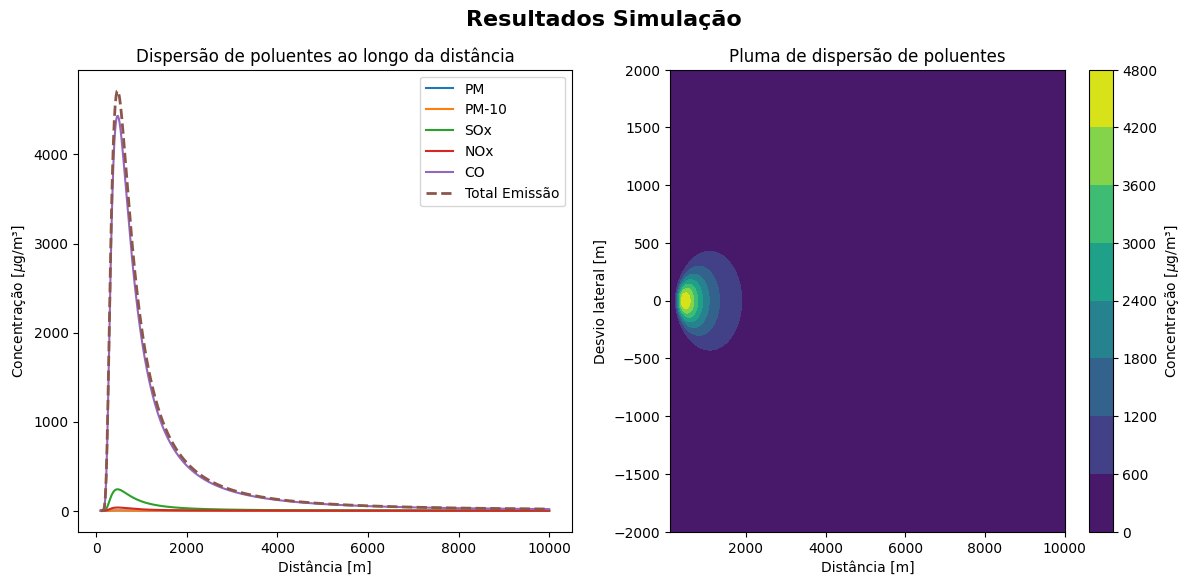

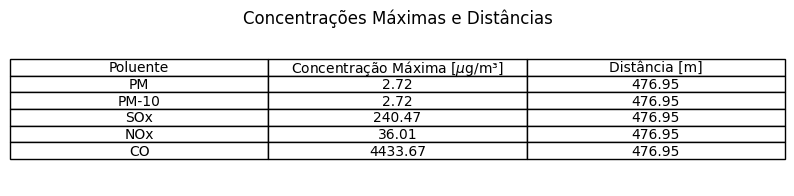

In [43]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 150,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\inputs\Emissões.csv", header=None, skiprows=1)
poluentes_df.columns = ['Poluentes', 'Emissão']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['Emissão'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
cobertura_nuvens = row['Cloud_Cover_[tenths]']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['Poluentes'], poluentes_df['Emissão']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

#### Simulação 3


Resultados Simulação
Classe de Estabilidade: C
A pluma caiu
383.13411684144154 367.5
Sobrelevação da pluma (Briggs): 15.63 m


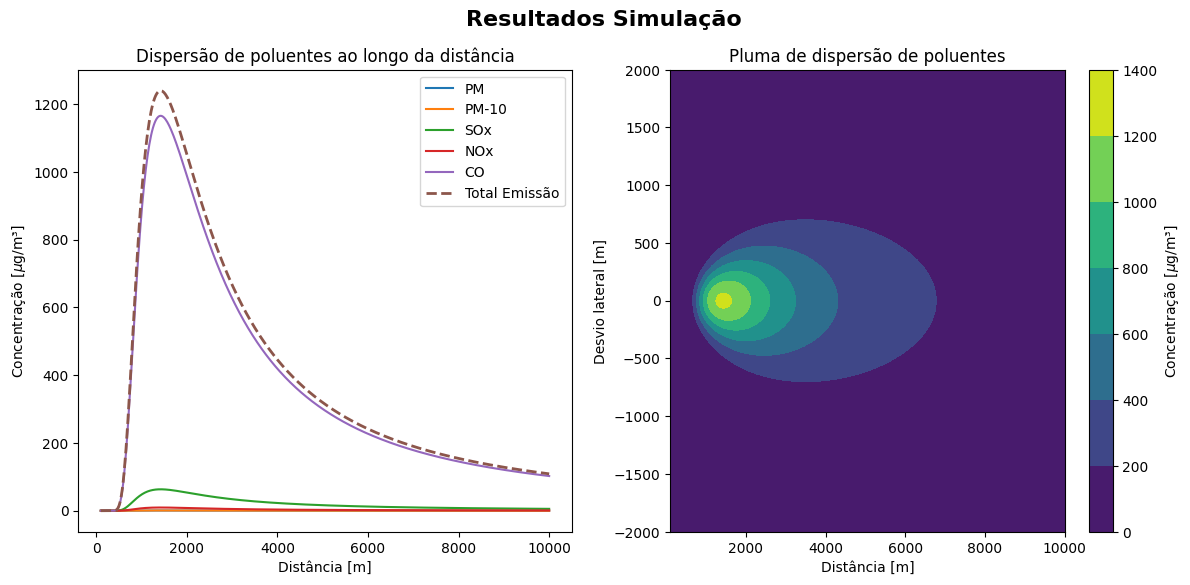

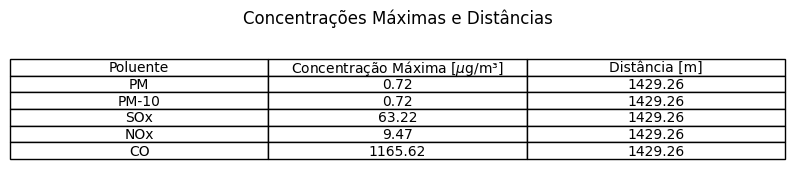

In [44]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 350,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\inputs\Emissões.csv", header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
cobertura_nuvens = row['Cloud_Cover_[tenths]']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

### Simulação 4


Resultados Simulação
Classe de Estabilidade: C
A pluma caiu
433.13411684144154 417.5
Sobrelevação da pluma (Briggs): 15.63 m


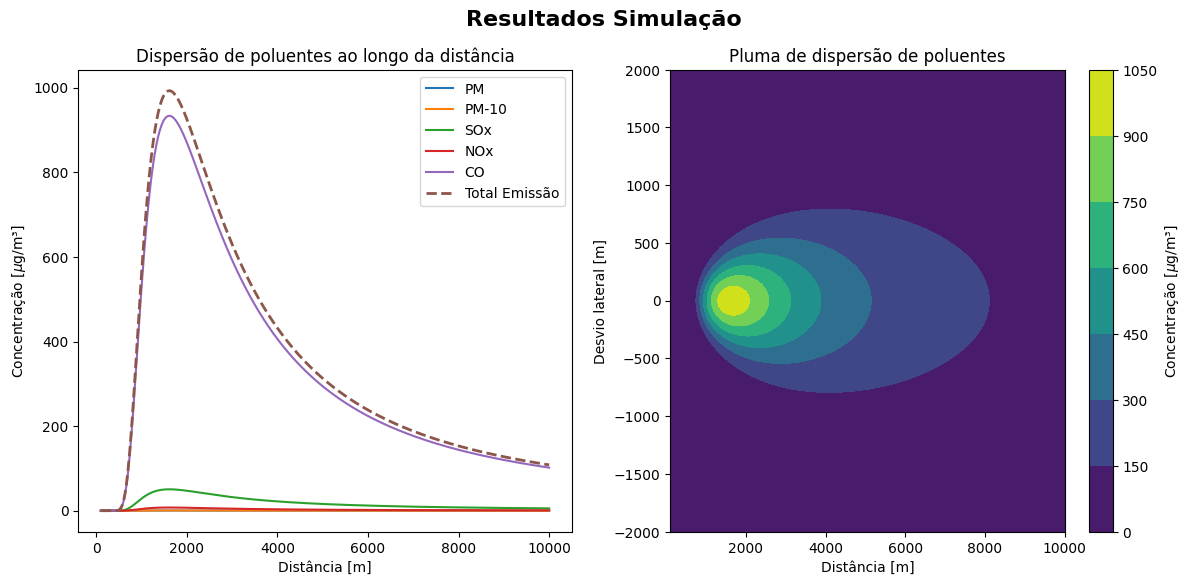

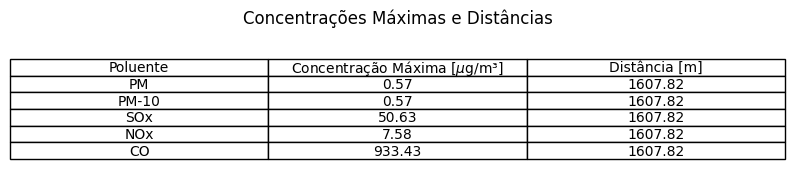

In [45]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 400,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\inputs\Emissões.csv", header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
cobertura_nuvens = row['Cloud_Cover_[tenths]']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

### Simulação final conforme a CONAMA491

Para estar em conformidade com as regulamentações ambientais vigentes, é essencial que as emissões de poluentes sejam controladas adequadamente. Sem a implementação de dispositivos de tratamento de gases, uma solução viável é a construção de uma chaminé com altura mínima de 450 metros. Esta altura é calculada para permitir que os poluentes se dispersem na atmosfera de forma a não exceder os limites permitidos para os seguintes poluentes:
https://www.legisweb.com.br/legislacao/?id=369516

1. PM:
Média anual: 20 µg/m³
Média de 24 horas: 60 µg/m³

2. PM10:
Média anual: 40 µg/m³
Média de 24 horas: 120 µg/m³

3. SOx:
Média de 24 horas: 20 µg/m³
Média de 1 hora: 500 µg/m³

4. NOx:
Média anual: 40 µg/m³
Média de 1 hora: 200 µg/m³

5. CO:
Média de 8 horas: 9 ppm (equivalente a 10.000 µg/m³)
Média de 1 hora: 35 ppm (equivalente a 40.000 µg/m³)


Resultados Simulação
Classe de Estabilidade: B
A pluma caiu
483.13411684144154 467.5
Sobrelevação da pluma (Briggs): 15.63 m


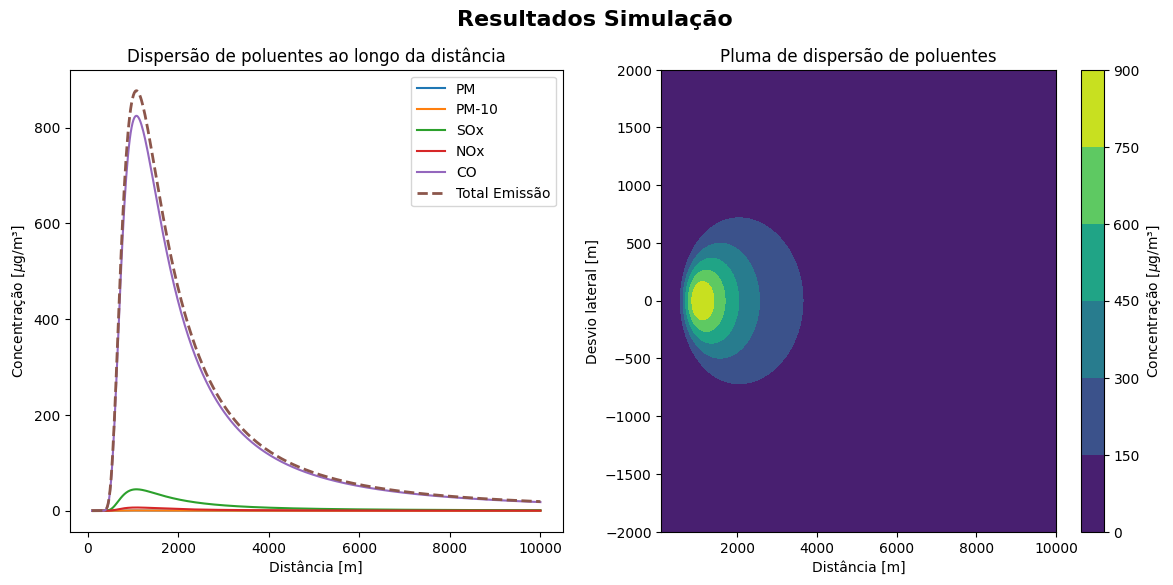

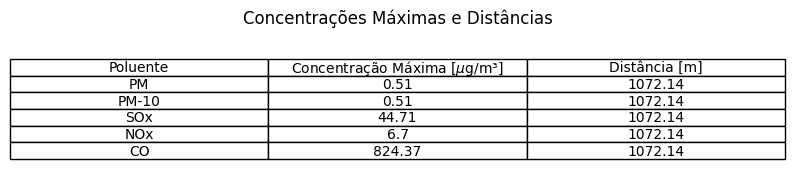

In [46]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 450,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r"C:\Users\bruna\OneDrive\Documentos\UFSC\Controle de Poluicao Atmosferica\ENS5173_20241\inputs\Emissões.csv", header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['Surface_Friction_Velocity_[meters/second]']
fluxo_calor_sensivel = row['Sensible_Heat_Flux_[Watt/meter^2]']
cobertura_nuvens = row['Cloud_Cover_[tenths]']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

Apesar dos esforços para aumentar a altura da chaminé da fábrica ao máximo permitido pelas diretrizes da Resolução CONAMA 491, a classificação da dispersão atmosférica permanece na categoria instável. Este cenário reforça a necessidade de adotar uma abordagem mais abrangente e integrada para a gestão das emissões atmosféricas. Além das intervenções físicas, como o aumento da altura da chaminé, é essencial implementar tecnologias avançadas de controle de poluição, como filtros de manga, filtros eletrostáticos e scrubbers, que podem significativamente reduzir a concentração de poluentes antes de serem liberados na atmosfera.